# Bayesian filtering: continuous case using a particle filter

## Create the data structures and functions

Load the libraries we need

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import math
import sys

Define the state variables $\mathbf{X}$ and the sensor variables $\mathbf{Y}$. In this case, the state variables consist of the $x$ and $y$ positions of the object and the sensor variables are the distances measured by sensors in the four corners of a square: lower left, upper left, lower right, and upper right.

In [2]:
x_names = [
    'pos_x',
    'pos_y'
]

x_names_long = [
    '$x$ position',
    '$y$ position'
]

y_names = [
    'LL',
    'UL',
    'LR',
    'UR'
]

y_names_long = [
    'Lower left',
    'Upper left',
    'Lower right',
    'Upper right'
]

In [3]:
num_x_vars = len(x_names)
num_y_vars = len(y_names)

Define the parameters of the initial state, the transition model and the sensor response model. In this case, the initial state is a two-dimensional Gaussian with mean of $(0,0)$ and a standard deviation of $\sigma_i = 0.1$. The transition model is a two-dimensional Gaussian random walk with a standard deviation of $\sigma_t = 0.1$. The sensor response model is that the sensors are placed at $(-1, -1)$, $(-1, 1)$, $(1, -1)$, and $(1, 1)$ and they measure the distance to the object with Gaussian error $\sigma_m = 0.2$.

In [4]:
initial_position = np.array([0.0, 0.0])
initial_error = 0.1
drift = 0.1
sensor_positions = np.array([
    [-1.0, -1.0],
    [-1.0, 1.0],
    [1.0, -1.0],
    [1.0, 1.0]
])
sensor_error = 0.2

Define a function that generates samples of the initial state $\mathbf{X}_0$.

In [5]:
initial_covariance = np.diagflat(np.repeat(initial_error**2, 2))

In [6]:
def x_initial_sample():
    return np.random.multivariate_normal(initial_position, initial_covariance)

Generate 1,000 samples and check that they have the properties we expect.

In [7]:
x_initial_samples = np.array([x_initial_sample() for i in range(1000)])

In [8]:
np.mean(x_initial_samples, 0)

array([-0.00073874, -0.00459123])

In [9]:
np.std(x_initial_samples, 0)

array([ 0.09447389,  0.09920261])

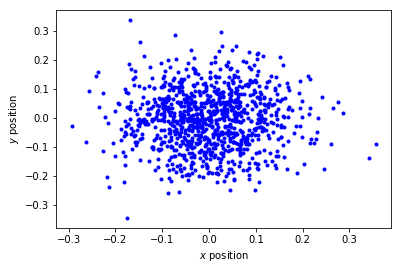

In [10]:
plt.plot(x_initial_samples[:,0], x_initial_samples[:,1], 'b.')
plt.xlabel(x_names_long[0])
plt.ylabel(x_names_long[1])
plt.show()

Define a function that generates samples of the state $\mathbf{X}_t$ given $\mathbf{X}_{t-1}$.

In [11]:
x_bar_x_prev_covariance = np.diagflat(np.repeat(drift**2,2))

In [12]:
def x_bar_x_prev_sample(x_prev):
    return np.random.multivariate_normal(x_prev, x_bar_x_prev_covariance)

Generate 1,000 samples (with $\mathbf{X}_{t-1}$ chosen arbitrarily) to make sure they have the properties we expect.

In [13]:
x_bar_x_prev_samples = np.array([x_bar_x_prev_sample(np.array([0.1, -0.2])) for i in range(1000)])

In [14]:
np.mean(x_bar_x_prev_samples, 0)

array([ 0.09236735, -0.19666317])

In [15]:
np.std(x_bar_x_prev_samples, 0)

array([ 0.10138381,  0.09914174])

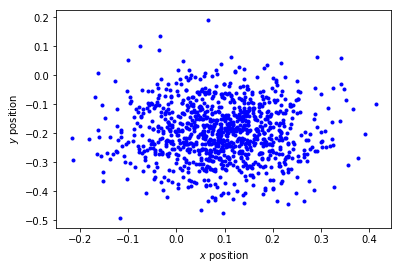

In [16]:
plt.plot(x_bar_x_prev_samples[:,0], x_bar_x_prev_samples[:,1], 'b.')
plt.xlabel(x_names_long[0])
plt.ylabel(x_names_long[1])
plt.show()

Define a function that returns the distances to the four sensors given $\mathbf{X}$.

In [17]:
def distances_to_sensors(x):
    return np.linalg.norm(np.tile(x,num_y_vars).reshape((num_y_vars, num_x_vars)) - sensor_positions, axis=1)

Try this out for a couple of values of $\mathbf{X}$ to make sure we get the results we expect.

In [18]:
distances_to_sensors(np.array([0, 0]))

array([ 1.41421356,  1.41421356,  1.41421356,  1.41421356])

In [19]:
math.sqrt(2)

1.4142135623730951

In [20]:
distances_to_sensors(np.array([-1, 0]))

array([ 1.        ,  1.        ,  2.23606798,  2.23606798])

In [21]:
math.sqrt(5)

2.23606797749979

Define a function that generates samples of the sensor readings $\mathbf{Y}$ given $\mathbf{X}$.

In [22]:
y_bar_x_covariance = np.diagflat(np.repeat(sensor_error**2,4))

In [23]:
def y_bar_x_sample(x):
    distances = distances_to_sensors(x)
    return np.random.multivariate_normal(distances, y_bar_x_covariance)

Generate 1,000 samples (with $\mathbf{X}$ chosen arbitrarily) to make sure they have the properties we expect.

In [24]:
y_bar_x_samples = np.array([y_bar_x_sample(np.array([-1, 0])) for i in range(1000)])

In [25]:
np.mean(y_bar_x_samples, 0)

array([ 0.98505265,  0.99181028,  2.24000798,  2.22507974])

In [26]:
np.std(y_bar_x_samples, 0)

array([ 0.1985487 ,  0.20897711,  0.19834888,  0.1992591 ])

Define a generic Gaussian probability density function.

In [27]:
def pdf_gaussian(x, mean, sd):
    return math.exp(-(x-mean)**2/(2*sd**2))/(math.sqrt(2*math.pi)*sd)

Plot the function to make sure it has the shape and normalization we expect.

In [28]:
x_range = np.arange(-10.0, 0.0, 0.01)

In [29]:
f_range = np.array([pdf_gaussian(x, -5.0, 1.0) for x in x_range])

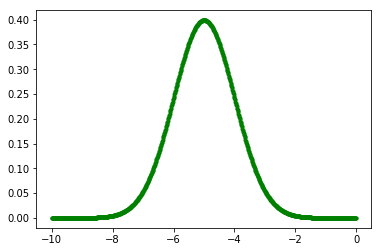

In [30]:
plt.plot(x_range, f_range, 'g.')
plt.show()

Define $f(\mathbf{Y} | \mathbf{X})$, the probability density function for the sensor readings $\mathbf{Y}$ given the state $\mathbf{X}$.

In [31]:
def f_y_bar_x(x, y):
    distances = distances_to_sensors(x)
    probability_densities = np.array([pdf_gaussian(y[i], distances[i], sensor_error) for i in range(num_y_vars)])
    return np.product(probability_densities)

Plot the dependence of $f(\mathbf{Y} | \mathbf{X})$ on the lower-left sensor reading, holding the values of all of the other sensor readings fixed, to make sure it has the shape we expect.

In [32]:
LL_range = np.arange(-2, 4, 0.01)

In [33]:
f_range = np.array([f_y_bar_x(np.array([0, 0]), np.array([LL, 1.4142, 1.4142, 1.4142])) for LL in LL_range])

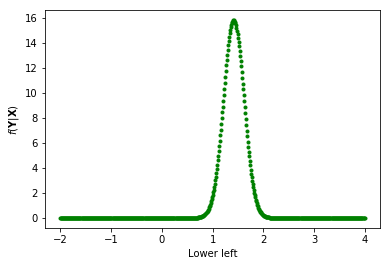

In [34]:
plt.plot(LL_range, f_range, 'g.')
plt.xlabel(y_names_long[0])
plt.ylabel('$f(\mathbf{Y} | \mathbf{X})$')
plt.show()

Check to make sure that $f(\mathbf{Y} | \mathbf{X})$ is normalized properly by evaluating the crude numerical integral of the function over $\mathbf{Y}$

In [35]:
integral = 0
for LL in np.arange(0, 3, 0.1):
    print LL
    for UL in np.arange(0, 3, 0.1):
        for LR in np.arange(0, 3, 0.1):
            for UR in np.arange(0, 3, 0.1):
                integral = integral + f_y_bar_x(np.array([0, 0]), np.array([LL, UL, LR, UR]))*0.0001

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9


In [36]:
integral

0.99999999999936207

## Generate simulated $\mathbf{X}$ and $\mathbf{Y}$ data

Set the number of timesteps and initialize the variables.

In [37]:
num_timesteps = 100
t = np.zeros(num_timesteps, dtype='float')
x_t = np.zeros((num_timesteps, num_x_vars), dtype='float')
y_t = np.zeros((num_timesteps, num_y_vars), dtype='float')

Calculate the data for $t=0$.

In [38]:
t[0] = 0.0

In [39]:
x_t[0] = x_initial_sample()

In [40]:
y_t[0] = y_bar_x_sample(x_t[0])

Calculate the data for $t>0$.

In [41]:
timestep_size = 1.0

In [42]:
for t_index in range(1,num_timesteps):
    t[t_index] = t[t_index - 1] + timestep_size
    x_t[t_index] = x_bar_x_prev_sample(x_t[t_index - 1])
    y_t[t_index] = y_bar_x_sample(x_t[t_index])

Plot the data to make sure it has the properties we expect.

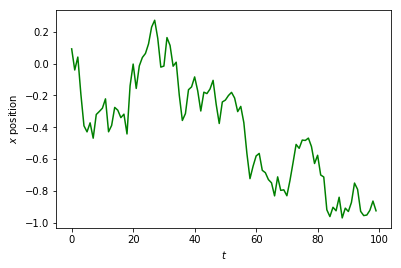

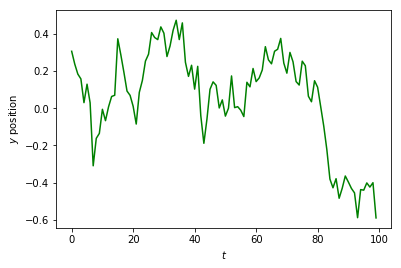

In [43]:
for x_var_index in range(num_x_vars):
    plt.plot(t, x_t[:, x_var_index], 'g-')
    plt.xlabel('$t$')
    plt.ylabel(x_names_long[x_var_index])
    plt.show()

In [44]:
distances_t = np.array([distances_to_sensors(x) for x in x_t])

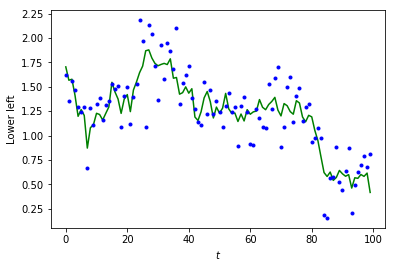

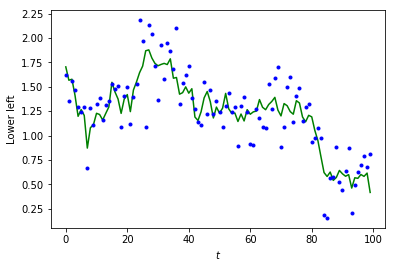

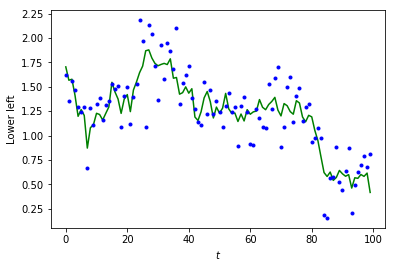

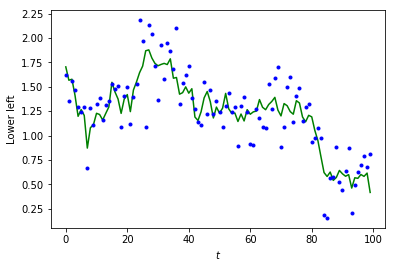

In [45]:
for y_var_index in range(num_y_vars):
    plt.plot(t, distances_t[:,0], 'g-')
    plt.plot(t, y_t[:,0], 'b.')
    plt.xlabel('$t$')
    plt.ylabel(y_names_long[0])
    plt.show()

## Sample the posterior distribution $f(\mathbf{X}_t | \mathbf{Y}_0, \mathbf{Y}_1, \ldots, \mathbf{Y}_t)$ using a particle filter

Set the number of particles and initialize variables.

In [46]:
num_particles = 50
particle_values = np.zeros((num_timesteps, num_particles, num_x_vars), dtype = 'float')
particle_weights = np.zeros((num_timesteps, num_particles), dtype = 'float')

Generate the particles for the initial state $\mathbf{X}_0$.

In [47]:
for particle_index in range(num_particles):
    particle_values[0, particle_index] = x_initial_sample()
    particle_weights[0, particle_index] = f_y_bar_x(particle_values[0, particle_index], y_t[0])
particle_weights[0] = particle_weights[0]/np.sum(particle_weights[0])

Check to see that these particles have the properties we expect.

In [48]:
np.sum(particle_weights[0])

1.0

In [49]:
np.average(particle_values[0], axis=0, weights = particle_weights[0])

array([ 0.07835782,  0.11520441])

In [50]:
x_t[0]

array([ 0.09279912,  0.30700308])

The weighted mean of the particles is not particularly close to the actual value of $\mathbf{X}_0$ because of sensor error and sampling error, but we expect the particles to converge and track the actual state as we generate successive sets of particles. Let's check that the weights roughly have the structure we expect, with higher weights for particles that are closer to the actual state.

In [51]:
np.linalg.norm(particle_values[0] - x_t[0], axis=1)

array([ 0.41762916,  0.23683055,  0.52283704,  0.36695082,  0.3425084 ,
        0.42462571,  0.54027887,  0.31939211,  0.50788597,  0.34804809,
        0.14971784,  0.45587412,  0.30247644,  0.29231361,  0.3072131 ,
        0.48435889,  0.22514127,  0.3501034 ,  0.19589649,  0.27894071,
        0.41678496,  0.32988071,  0.39007162,  0.28552001,  0.11659663,
        0.26840337,  0.42469728,  0.3301679 ,  0.30335913,  0.27329941,
        0.31938595,  0.27763309,  0.40939191,  0.22325655,  0.33469155,
        0.28689849,  0.30734651,  0.44926976,  0.49156604,  0.32052597,
        0.25940925,  0.34877704,  0.08590362,  0.22867713,  0.46351124,
        0.23744474,  0.48404035,  0.25767201,  0.48473098,  0.25978908])

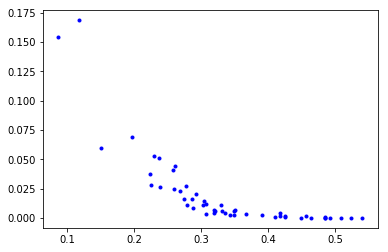

In [52]:
plt.plot(np.linalg.norm(particle_values[0] - x_t[0], axis=1), particle_weights[0], 'b.')
plt.show()

We can see the effect of the sensor error and the sampling error, but the particles that are closer to the actual state do indeed tend to have higher weights.

Calculate the particles for all times $t>0$.

In [53]:
for t_index in range(1, num_timesteps):
    for particle_index in range(num_particles):
        previous_particle = particle_values[t_index - 1, np.random.choice(num_particles, p=particle_weights[t_index - 1])]
        particle_values[t_index, particle_index] = x_bar_x_prev_sample(previous_particle)
        particle_weights[t_index, particle_index] = f_y_bar_x(particle_values[t_index, particle_index], y_t[t_index])
    particle_weights[t_index] = particle_weights[t_index]/np.sum(particle_weights[t_index])

Calculate the sample means of the particles at each time $t$.

In [54]:
x_mean_particle = np.average(
    particle_values, 
    axis=1, 
    weights=np.repeat(particle_weights, 2).reshape((num_timesteps, num_particles, 2))
)

Plot these sample means against the actual values of $\mathbf{X}_t$.

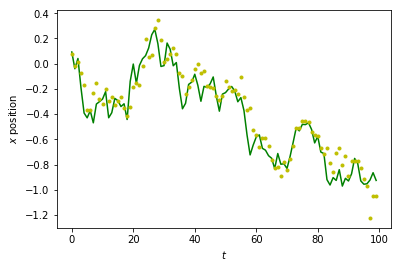

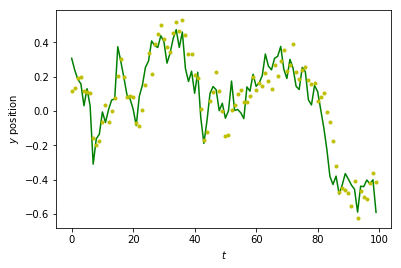

In [55]:
for x_var_index in range(num_x_vars):
    plt.plot(t, x_t[:,x_var_index], 'g-')
    plt.plot(t, x_mean_particle[:,x_var_index], 'y.')
    plt.xlabel('$t$')
    plt.ylabel(x_names_long[x_var_index])
    plt.savefig('particle_means_continuous_{}.png'.format(x_names[x_var_index]))
    plt.show()


The particle filter tracks extremely well, even with only 50 particles.